<h1>Full Feature Pipeline & Modeling</h1>
<h3>Libraries & Helper functions</h3>

In [52]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model, ensemble, svm, metrics, preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from contextlib import contextmanager
import random
import os
from os.path import expanduser
import sys

# Turn off the chained assignment warning, we're not doing anything wrong... I checked...
pd.options.mode.chained_assignment = None  # default='warn'

In [53]:
# Create context manager to deal with postgres connection
@contextmanager
def connect_to_db():
    # Get home directory and password from ~/.pgpass file
    home = expanduser("~")
    pg_file = open(home + "/.pgpass", 'r')
    pgpass = pg_file.readlines()
    pg_password = pgpass[0].split(':')[4].replace('\n', '')
    
    try:
          conn = psycopg2.connect(database="infonavit",
                        user="infonavit",
                        password=pg_password,
                        host="dssgsummer2014postgres.c5faqozfo86k.us-west-2.rds.amazonaws.com")
          yield conn
    except:
        print "Error establishing DB Connection. Try again fool."
    finally:
          conn.close()   

In [3]:
def sub_sample(x_df, y_df, percent_abd):
    """ Function to return a random subsample of training points with the given percent split
    Returns x_df and corresponding y_df with y_df[y_var].sum() / y_df.shape[0] = percent_abd """
    # Define the abandoned variable
    y_var = "abandoned"
    num_abd = y_df[y_var].sum()
    num_not_abd = int((float(1.0 - percent_abd) / float(percent_abd)) * num_abd)
    
    print "Subsampling {} abandoned homes, and {} non-abandoned w/ratio {}.".format(num_abd, num_not_abd, percent_abd)
    
    # Check if that many non-abandoned houses actually exist in data set and raise exception if not
    if (y_df.shape[0] - y_df[y_var].sum()) - num_not_abd < 0:
        print "Not enough non-abandoned houses to fulfill {} percent abandoned requirement.".format(percent_abd)
        num_not_abd = (y_df.shape[0] - y_df[y_var].sum())
        print "Using {} non-abandoned homes instead.".format(num_not_abd)
        #raise ValueError("Not enough non-abandoned houses to fulfill {} percent abandoned requirement.".format(percent_abd))
    
    # Get all abanadoned abandoned loans
    abd_x = x_df.loc[y_df[y_var] == True] 
    abd_y = y_df.loc[y_df[y_var] == True]
    
    # Get indexes of all non-abandoned loans
    non_abd_idxs = (y_df.loc[y_df[y_var] == False]).index
    
    # Get random subset of indexes equal to the partition size
    non_abd_idx_subset = np.random.choice(non_abd_idxs, num_not_abd, replace=False)
    
    # Select out those rows
    non_abd_x = x_df.loc[non_abd_idx_subset]
    non_abd_y = y_df.loc[non_abd_idx_subset]
    
    # Concatenate the abandoned and non abandoned to get the final subsets
    x_df_sub = pd.concat([abd_x, non_abd_x])
    y_df_sub = pd.concat([abd_y, non_abd_y])
    
    return (x_df_sub, y_df_sub)

In [4]:
%matplotlib inline

def print_model_stats(model, x_test, y_test, feature_list, save_file_name="model_eval.html"):
    """Given a model, x testing set, y testing set, and a list of feature 
    descriptions, this function computes the ROC and PR curves for the model
    as well as printing a confusion matrix and the feature importances."""
    # Get the parameters used in the model
    model_params = model.get_params()
    print "Model Parameters:"
    print "-"*20
    for elem in model_params:
        print "{}: {}".format(elem, model_params[elem])
    print "-"*20

    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)
    y_pred_true = [tup[1] for tup in y_pred_prob]
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_true)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show()
    
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_true, pos_label=True)

    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall (TP / (TP + FN))')
    plt.ylabel('Precision (TP / (TP + FP))')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="lower left")
    plt.show()
    
    labels = [1, 0]
    label_titles = ["abandoned", "inhabited"]
    cm = metrics.confusion_matrix(y_test, y_pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)

    ax.text(-0.25, 0, "{}".format(cm[0][0]), fontsize=14)
    ax.text(0.75, 0, "{}".format(cm[0][1]), fontsize=14)
    ax.text(-0.25, 1, "{}".format(cm[1][0]), fontsize=14)
    ax.text(0.75, 1, "{}".format(cm[1][1]), fontsize=14)

    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + label_titles)
    ax.set_yticklabels([''] + label_titles)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print "Feature Importances:"
    for tup in sorted(zip(feature_list, model.feature_importances_), 
                      key= lambda x: x[1])[::-1]: 
        print tup

In [5]:
def write_html(model, x_test, y_test, feature_list, save_file_name="model_results/model_eval.html", train_range=(0, 0), test_range=(0, 0)):
    # Get the parameters used in the model
    model_params = model.get_params()
    
    model_name = save_file_name.split(".")[0]
    
    roc_curve_file = model_name + "_ROC_Curve.png"
    pr_curve_file = model_name + "_PR_Curve.png"
    cf_mat_file = model_name + "_Confusion_Mat.png"
    
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)
    y_pred_true = [tup[1] for tup in y_pred_prob]
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_true)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.clf()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.savefig(roc_curve_file)
    
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_true, pos_label=True)

    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall (TP / (TP + FN))')
    plt.ylabel('Precision (TP / (TP + FP))')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="lower left")
    plt.savefig(pr_curve_file)
    
    plt.clf()
    labels = [1, 0]
    label_titles = ["abandoned", "inhabited"]
    cm = metrics.confusion_matrix(y_test, y_pred, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)

    ax.text(-0.25, 0, "{}".format(cm[0][0]), fontsize=14)
    ax.text(0.75, 0, "{}".format(cm[0][1]), fontsize=14)
    ax.text(-0.25, 1, "{}".format(cm[1][0]), fontsize=14)
    ax.text(0.75, 1, "{}".format(cm[1][1]), fontsize=14)

    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + label_titles)
    ax.set_yticklabels([''] + label_titles)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(cf_mat_file)
    
    save_file = open(save_file_name, 'w')
    save_file.write("<!DOCTYPE HTML PUBLIC \"-//W3C//DTD HTML 4.01 Transitional//EN\">\n")
    save_file.write("<html lang=\"en\">\n")
    save_file.write("<head>\n")
    save_file.write("<meta http-equiv=\"content-type\" content=\"text/html; charset=utf-8\">\n")
    save_file.write("<h1>Model Evaluation Sheet</h1>\n")
    save_file.write("</head>\n")
    save_file.write("<body>\n")
    save_file.write("Training Data Range: {} to {}<br>".format(train_range[0], train_range[1]))
    save_file.write("Testing Data Range: {} to {}<br>".format(test_range[0], test_range[1]))
    save_file.write("<br>Model AUC: {}<br>".format(roc_auc))
    save_file.write("-"*100 + "<br>")
    for elem in model_params:
        save_file.write("{}: {}<br>".format(elem, model_params[elem]))
    save_file.write("-"*100 + "<br>")
    
    save_file.write("<IMG SRC=\"{}\"></IMG>\n<br></br>".format(roc_curve_file.split('/')[1]))
    save_file.write("<IMG SRC=\"{}\"></IMG>\n<br></br>".format(pr_curve_file.split('/')[1]))
    save_file.write("<IMG SRC=\"{}\"></IMG>\n<br></br>".format(cf_mat_file.split('/')[1]))
                    
#     save_file.write("<h3>Feature Importances:</h3>\n<br>")
#     for tup in sorted(zip(feature_list, model.feature_importances_), 
#                       key= lambda x: x[1])[::-1]: 
#         save_file.write("{}<br>".format(tup))
    
    save_file.write("</body></html>")
    save_file.close()

<h3>Loading Data from PostgreSQL</h3>

In [6]:
# Define time ranges for train/test split
# Note time ranges are inclusive of the left value, 
# and do not include the right value, 
# so test_range = (2011, 2011) returns nothing
train_range = (2010, 2011)
test_range = (2011, 2012)

In [7]:
with connect_to_db() as conn:
    cols = pd.read_sql("select column_name from information_schema.columns where table_name='master_loan_features';", conn)

In [7]:
with connect_to_db() as conn:    
    x_query = ("SELECT * FROM master_loan_features "
               + "WHERE year_granted >= {} and year_granted < {};".format(train_range[0], test_range[1]))
    y_query = ("SELECT abandoned FROM master_loan_features "
               + "WHERE year_granted >= {} and year_granted < {};".format(train_range[0], test_range[1]))
    x = pd.read_sql(x_query, conn)
    y = pd.read_sql(y_query, conn)

<h3>Removing Columns & NA Rows</h3>

In [8]:
# Create a list of columns that won't be used in prediction to drop
non_features = ['cv_credito',
                'coloniaid',
                'colonia_num_loans',
                'colonia_num_abd',
                'year',
                'nom_mun',
                'mun_region',
                'mun_geo_zone',
                'abandoned']

In [9]:
# Drop the non-features columns
for col_name in non_features:
    try:
        x.drop(col_name, axis=1, inplace=True)
    except ValueError:
        print "Column \"{}\" not found in dataframe... passing..".format(col_name)
        
# Drop all rows with NA values from both x & y sets
print "Droping all rows which contain NA's..."
print "Initial number of loans = {}".format(x.shape[0])
x.dropna(axis=0, inplace=True)
y = y.iloc[x.index]
print "New number of loans = {}".format(x.shape[0])

Column "year" not found in dataframe... passing..
Column "nom_mun" not found in dataframe... passing..
Droping all rows which contain NA's...
Initial number of loans = 602684
New number of loans = 585246


<h3>Feature Scaling (SVM)</h3>

In [18]:
scaler = preprocessing.StandardScaler()
for var in list(x):
    if var != "year_granted":
        x[var] = scaler.fit_transform(x[var])

/opt/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))
/opt/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:332: UserWarning: StandardScaler assumes floating point values as input, got bool
  "got %s" % (estimator, X.dtype))


<h3>Splitting Train/Test Sets</h3>

In [10]:
# Split based on years
x_train = x.loc[x["year_granted"].isin(range(train_range[0], train_range[1]))]
y_train = y.loc[x["year_granted"].isin(range(train_range[0], train_range[1]))]
x_test = x.loc[x["year_granted"].isin(range(test_range[0], test_range[1]))]
y_test = y.loc[x["year_granted"].isin(range(test_range[0], test_range[1]))]

In [11]:
x_train_sub, y_train_sub = sub_sample(x_train, y_train, 0.50)

Subsampling 18861 abandoned homes, and 18861 non-abandoned w/ratio 0.5.


In [12]:
# Now drop the year columns since we dont need them for splitting anymore
x_train_sub.drop('year_granted', axis=1, inplace=True)
x_test.drop('year_granted', axis=1, inplace=True)

In [13]:
# Extract a feature list for the feature importance extraction
feature_list = list(x_train_sub)

In [14]:
# Convert to numpy arrays for sklearn
x_train_sub = np.array(x_train_sub).astype(float)
y_train_sub = np.ravel(np.array(y_train_sub))
x_test_np = np.array(x_test).astype(float)
y_test_np = np.ravel(np.array(y_test))

<h3>Training & Evaluating a model</h3>

In [15]:
rfc = ensemble.RandomForestClassifier(n_estimators = 500, max_depth=10, n_jobs=6)

In [16]:
rfc = rfc.fit(x_train, y_train)

/opt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


Testing w/ 5000 estimators
Saved.


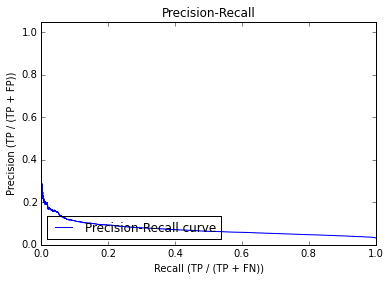

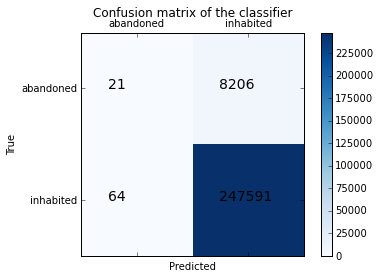

In [39]:
for max_dep in range(1,25, 5)
for num_estimators in [50, 100, 250, 500, 1000, 1500, 2000, 2500, 5000]:
    print "Testing w/ {} estimators".format(num_estimators)
    save_file_name = "model_results/rfc_{}_estimators.html".format(num_estimators)
    # Initalize Random Forest Classifier w/ parameters
    rfc = ensemble.RandomForestClassifier(n_estimators = num_estimators, max_depth=15, n_jobs=2)
    # Train RFC on training set
    rfc = rfc.fit(x_train_sub, y_train_sub)
    write_html(rfc, x_test_np, y_test_np, feature_list, save_file_name=save_file_name, train_range=train_range, test_range=test_range)
    print "Saved."

In [75]:
# Get random subset of indexes equal to the partition size
random_subset = np.random.choice(x_train_sub.index, 15000, replace=False)

# Select out those rows
x_train_sub_sub = x_train_sub.loc[random_subset]
y_train_sub_sub = y_train_sub.loc[random_subset]

In [76]:
# Convert to numpy arrays for sklearn
x_train_sub_sub = np.array(x_train_sub_sub).astype(float)
y_train_sub_sub = np.ravel(np.array(y_train_sub_sub))
x_test_np = np.array(x_test).astype(float)
y_test_np = np.ravel(np.array(y_test))

In [ ]:
svm_clf = svm.SVC(kernel='linear', C=0.5, probability=True, cache_size=10000, tol=0.01)
svm_clf = svm_clf.fit(x_train_sub_sub, y_train_sub_sub)
write_html(svm_clf, x_test_np, y_test_np, feature_list, save_file_name="model_results/svm_linear_10k_eval.html", train_range=train_range, test_range=test_range)

In [19]:
# Initalize Random Forest Classifier w/ parameters
rfc = ensemble.RandomForestClassifier(n_estimators = 1000, max_depth=20, n_jobs=20)
# Train RFC on training set
rfc = rfc.fit(x_train_sub, y_train_sub)

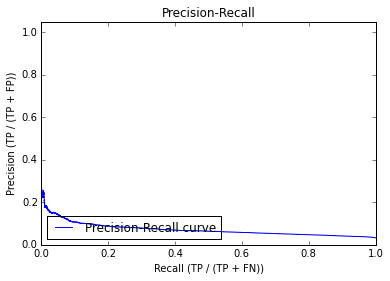

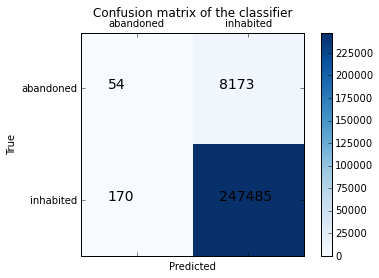

In [26]:
write_html(rfc, x_test_np, y_test_np, feature_list, train_range=train_range, test_range=test_range)

<h3>Creating New Feature Columns</h3>

In [35]:
# Create a boolean column for when the risk is bad, or below 2000
x["risk_bad"] = x["personal_risk_index"] < 2000

In [37]:
# Apply an arbitrary function to a dataframe row-wise
def row_func(row):
    return math.log(row["personal_age"])

x["log_age"] = x.apply(row_func, axis=1)


KeyboardInterrupt
